Import Libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import keras

Importing MNIST Dataset

In [39]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


Plotting 9 random images

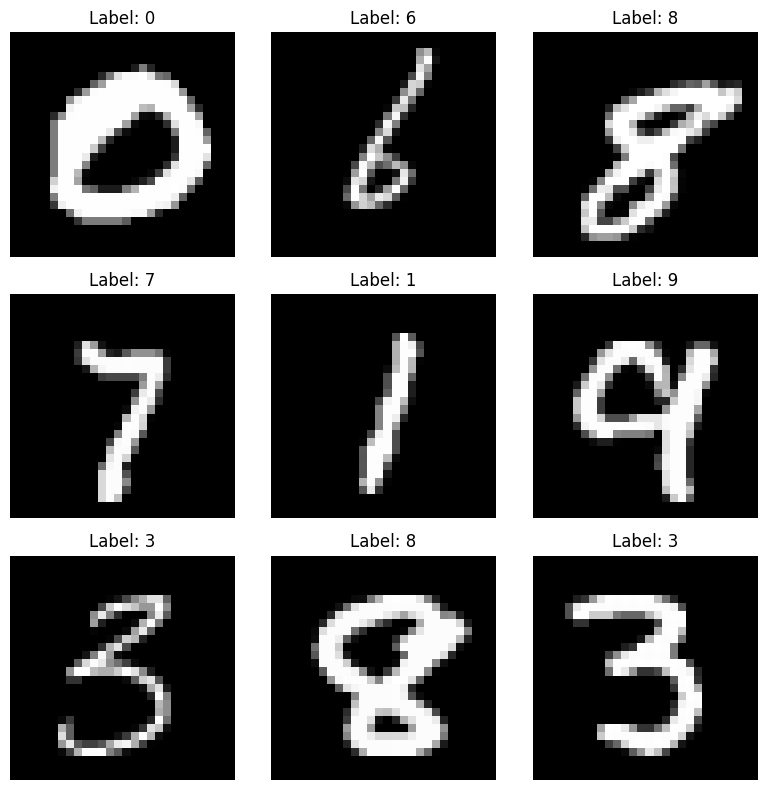

In [40]:
# Select 9 random images from the training set
num_images = 9
random_indices = np.random.choice(X_train.shape[0], num_images, replace=False)
images_to_display = X_train[random_indices]
labels_to_display = y_train[random_indices]

plt.figure(figsize=(8, 8))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_to_display[i], cmap='gray')
    plt.title(f"Label: {labels_to_display[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Utilities function

In [41]:
def sigmoid(z):
  z = np.clip(z, -500, 500)
  return 1 / (1 + np.exp(-z))

def softmax(z):
  exp_z=np.exp(z-np.max(z,axis=0,keepdims=True))
  return exp_z/np.sum(exp_z,axis=0,keepdims=True)

def relu(Z):
  A = np.maximum(0,Z)
  return A

def one_hot(y, num_classes=10):
    m = len(y)
    one_hot_y = np.zeros((num_classes, m))
    one_hot_y[y, np.arange(m)] = 1
    return one_hot_y

def sigmoid_derivative(z):
    a=sigmoid(z);
    return a * (1 - a)

def relu_derivative(dA,Z):
  dZ = np.array(dA, copy=True)
  dZ[Z <= 0] = 0
  return dZ

def cross_entropy_loss(AL, Y):
    m = Y.shape[1]
    epsilon = 1e-9
    AL = np.clip(AL, epsilon, 1. - epsilon)
    loss = -np.sum(Y * np.log(AL)) / m
    return loss

Neural Network Implementation

In [42]:
class NeuralNetwork:
  def __init__(self,n_layers,n_nodes):
    self.layer=n_layers
    self.nodes=n_nodes

  def printDetails(self):
    print(f"Number of layers in network are :{self.layer}")
    print(f"Number of nodes are {self.nodes}")
    print("Weight matrix shape")
    for i in range(0,self.layer+1):
      print(f"Weight at layer {i+1} is : {self.parameters['W'+str(i+1)].shape}")
    print("Bias matrix shape")
    for i in range(0,self.layer+1):
      print(f"Weight at layer {i+1} is : {self.parameters['b'+str(i+1)].shape}")


  def trainModel(self,X,Y,hidden_layer_activation='sigmoid',num_iters=1000,learning_rate=0.01):
    if len(X[0])!=len(Y):
      print(len(X[0]))
      print(len(Y))
      print("dimensions not match")
      self.parameters={}
      return
    y=one_hot(Y)
    parameters=self.initializeParameters(X)
    self.parameters=parameters
    self.hidden_layer_activation_for_prediction = hidden_layer_activation # Store activation for prediction
    self.losses = [] # Initialize list to store loss values
    self.epochs = [] # Initialize list to store epoch numbers
    for key,value in parameters.items():
      print(f"{key}->{value.shape}")
    self.caches={}
    for it in range(1,num_iters+1):
      # forward prop
      a=np.array(X)
      for i in range(0,self.layer+1):
        w=self.parameters["W"+str(i+1)]
        b=self.parameters["b"+str(i+1)]
        if i==self.layer:
          a=self.forwardPropagationActivation(a,w,b,i,'softmax')
        else:
          if hidden_layer_activation=='sigmoid':
            a=self.forwardPropagationActivation(a,w,b,i,'sigmoid')
          else:
            a=self.forwardPropagationActivation(a,w,b,i,'relu')

      # backward prop
      grads=self.backwardPropagation(y,hidden_layer_activation)
      self.update_parameters(grads,learning_rate)

      if it%50==0:
        loss=cross_entropy_loss(a,y)
        self.losses.append(loss) # Store loss
        self.epochs.append(it) # Store epoch
        print(f"Epoch {it}, Loss: {loss}")

  def initializeParameters(self,X):
    parameters={}

    # 1st layer weight
    w=np.random.randn(self.nodes[0],len(X))*0.01
    b=np.zeros((self.nodes[0],1))
    parameters["W1"]=w
    parameters["b1"]=b
    for i in range(1,self.layer):
      w=np.random.randn(self.nodes[i],self.nodes[i-1])*0.01
      b=np.zeros((self.nodes[i],1))
      parameters["W"+str(i+1)]=w
      parameters["b"+str(i+1)]=b

    # final weights before output layer (10,n[l-1])
    w=np.random.randn(10,self.nodes[self.layer-1])*0.01
    b=np.zeros((10,1))
    parameters["W"+str(self.layer+1)]=w
    parameters["b"+str(self.layer+1)]=b
    return parameters

  def forwardLinear(self,A,w,b):
    z=np.dot(w,A)+b
    cache=(A,w,b)
    return z,cache

  def forwardPropagationActivation(self,A,w,b,i,activation='sigmoid'):
    z,linear_cache=self.forwardLinear(A,w,b)
    if activation=='sigmoid':
      a_new=sigmoid(z)
    elif activation=='softmax':
      a_new=softmax(z)
    elif activation=='relu':
      a_new=relu(z)
    cache=(a_new,linear_cache)
    # self.caches.append(cache)
    self.caches["A"+str(i)]=A
    self.caches["A"+str(i+1)]=a_new
    self.caches["Z"+str(i+1)]=z
    return a_new

  def backwardPropagation(self,y,hidden_layer_activation='sigmoid'):
    grads={}
    L=self.layer+1
    m=self.caches["A0"].shape[1]
    cache=self.caches

    dZL = cache[f"A{L}"] - y
    grads[f"dW{L}"] = (1/m) * np.dot( dZL,cache[f"A{L-1}"].T)
    grads[f"db{L}"] = (1/m) * np.sum(dZL, axis=1, keepdims=True)
    dA_prev=np.dot(self.parameters[f"W{L}"].T,dZL)
    temp=grads[f"dW{L}"].shape
    # print(f"Shape of dW[{L}] is {temp}")
    temp=grads[f"db{L}"].shape
    # print(f"Shape of db[{L}] is {temp}")
    # print(f"Shape of dZL is {dZL.shape}")
    # print(f"Shape of dA_prev is {dA_prev.shape}")
    # Hidden layers
    # dZ_next=dZL
    for i in reversed(range(1, L)):
        # print("************************")
        # print(f"solving for {i} layer")
        # print("************************")
        w=self.parameters[f"W{i+1}"]
        # print(f"Shape of W{i+1} is {w.T.shape}")
        # print(f"Shape of dz_next is {dZ_next.shape}")
        # dA = np.dot(self.parameters[f"W{i+1}"].T,dZ_next)
        # temp=cache[f"A{i}"].shape
        # print(f"Shape of a is {temp}")
        z=cache[f"Z{i}"]
        # print(f"Shape of Z{i} is {z.shape}")
        dZ=None
        if hidden_layer_activation=='sigmoid':
          dZ = dA_prev * sigmoid_derivative(z)
        else:
          dZ = relu_derivative(dA_prev,z)
        # print(f"Shape of dZ{i} is {dZ.shape}")
        # print(f"Shape of A[i-1] is "+str(cache[f"A{i-1}"].shape))
        grads[f"dW{i}"] = (1/m) * np.dot( dZ,cache[f"A{i-1}"].T)
        # print(f"Dimension of dw{i} is "+str(grads[f"dW{i}"].shape))
        grads[f"db{i}"] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev=np.dot(self.parameters[f"W{i}"].T,dZ)
        # dZ_next = dZ
    return grads

  def update_parameters(self, grads, learning_rate):
    L=self.layer+1
    # for key,value in grads.items():
    #   print(f"{key}->{value.shape}")
    for i in range(1, L+1):
        self.parameters[f"W{i}"] -= learning_rate * grads[f"dW{i}"]
        self.parameters[f"b{i}"] -= learning_rate * grads[f"db{i}"]

  def forwardPropagationPrediction(self,A,w,b,activation='sigmoid'):
    z,_=self.forwardLinear(A,w,b)
    if activation=='sigmoid':
      a_new=sigmoid(z)
    elif activation=='softmax':
      a_new=softmax(z)
    elif activation=='relu':
      a_new=relu(z)
    return a_new

  def predict(self,X):
    a=X
    for i in range(0,self.layer+1):
      w=self.parameters[f"W{i+1}"]
      b=self.parameters[f"b{i+1}"]
      if i==self.layer:
        # softmax
        a=self.forwardPropagationPrediction(a,w,b,'softmax')
      else:
        a=self.forwardPropagationPrediction(a,w,b,self.hidden_layer_activation_for_prediction)
    prediction=np.argmax(a, axis=0)
    return prediction

  def evaluate(self, X, Y):
    preds = self.predict(X)
    accuracy = np.mean(preds == Y)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

Training Custom Model

In [43]:
X_train = X_train.reshape(X_train.shape[0], -1).T / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).T / 255.0

In [44]:
print(f"Reshaped and normalized X_train shape: {X_train.shape}")
print(f"Reshaped and normalized X_test shape: {X_test.shape}")

Reshaped and normalized X_train shape: (784, 60000)
Reshaped and normalized X_test shape: (784, 10000)


In [45]:
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (60000,)
y_test shape: (10000,)


In [46]:
n_layers = 1
hidden_nodes = [128]

model = NeuralNetwork(n_layers, hidden_nodes)

print("Starting model training...")
model.trainModel(X_train, y_train, hidden_layer_activation='relu', num_iters=1000, learning_rate=0.01)
print("Model training finished.")

Starting model training...
W1->(128, 784)
b1->(128, 1)
W2->(10, 128)
b2->(10, 1)
Epoch 50, Loss: 2.2977838074553856
Epoch 100, Loss: 2.2911191945202125
Epoch 150, Loss: 2.2820197292249693
Epoch 200, Loss: 2.2688372967680226
Epoch 250, Loss: 2.249535638949396
Epoch 300, Loss: 2.2215478125088683
Epoch 350, Loss: 2.1817282455157825
Epoch 400, Loss: 2.126691197392286
Epoch 450, Loss: 2.0534783930025595
Epoch 500, Loss: 1.9603718914653228
Epoch 550, Loss: 1.8480972672900615
Epoch 600, Loss: 1.7211413653567382
Epoch 650, Loss: 1.5877422717102876
Epoch 700, Loss: 1.4573715904336313
Epoch 750, Loss: 1.3373141500695562
Epoch 800, Loss: 1.231042478637312
Epoch 850, Loss: 1.138905710213099
Epoch 900, Loss: 1.0596114539277832
Epoch 950, Loss: 0.9913591974202348
Epoch 1000, Loss: 0.9323926630188036
Model training finished.


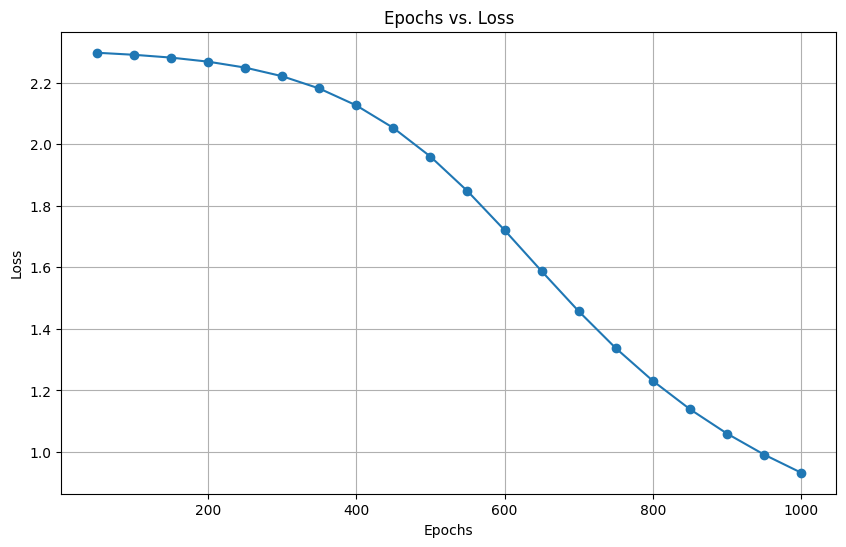

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(model.epochs, model.losses, marker='o', linestyle='-')
plt.title('Epochs vs. Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [49]:
model.evaluate(X_test, y_test)

Accuracy: 79.52%


np.float64(0.7952)